<a href="https://colab.research.google.com/github/Rimon-Roy/ML-Projects/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Setup and Data Initialization

## Importing Necessary Libraries

In [1]:
# Importing essential libraries
import numpy as np                     # For numerical operations
import pandas as pd                    # For data manipulation and analysis
import matplotlib.pyplot as plt        # For data visualization
import seaborn as sns                  # For enhanced data visualization
from sklearn.cluster import KMeans     # For K-means clustering
from sklearn.preprocessing import StandardScaler # For feature scaling
from sklearn.decomposition import PCA  # For dimensionality reduction
from scipy.stats import zscore         # For outlier detection
import warnings                        # To ignore warnings
warnings.filterwarnings('ignore')      # Suppress warnings for clean output

# Displaying settings
pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Limiting float decimal points for better readability


## Loading the Dataset

In [2]:
# Load the dataset
file_path = '/content/drive/MyDrive/Data Sets/data.csv'  # Path to your dataset
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Display the first few rows of the dataset to get an overview
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.550,17850.000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.390,17850.000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.750,17850.000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.390,17850.000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.390,17850.000,United Kingdom


# Initial Data Analysis

## Dataset Overview

In [3]:
# Step 2.1 | Dataset Overview

# Checking the shape of the dataset (number of rows and columns)
print("Dataset Shape:", df.shape)

# Displaying information about the dataset, including data types and non-null counts
print("\nDataset Information:")
df.info()

# Checking for missing values
print("\nMissing Values in each column:")
print(df.isnull().sum())

# Checking the unique values in categorical columns (if any)
print("\nUnique values in each column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")


Dataset Shape: (541909, 8)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB

Missing Values in each column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Unique values in each column:
InvoiceNo: 25900 unique values
StockCode: 4070 unique values
Description: 4223 unique values
Qua

## Summary Statistics

In [4]:
# Step 2.2 | Summary Statistics

# Displaying descriptive statistics for numeric columns
print("\nSummary Statistics:")
df.describe().T  # Transposing for better readability



Summary Statistics:


,count,mean,std,min,25%,50%,75%,max
Quantity,541909.000,9.552,218.081,-80995.000,1.000,3.000,10.000,80995.000
UnitPrice,541909.000,4.611,96.760,-11062.060,1.250,2.080,4.130,38970.000
CustomerID,406829.000,15287.691,1713.600,12346.000,13953.000,15152.000,16791.000,18287.000


# Data Cleaning & Transformation

## Handling Missing Values

In [5]:
# Step 3.1 | Handling Missing Values

# Drop rows with missing 'CustomerID' as it is crucial for customer segmentation
df = df.dropna(subset=['CustomerID'])

# Drop rows with missing 'Description' since it's not essential for segmentation
df = df.dropna(subset=['Description'])

# Checking the dataset after handling missing values
df.isnull().sum()


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## Handling Duplicates

In [6]:
# Step 3.2 | Handling Duplicates

# Dropping duplicates if any
df = df.drop_duplicates()

# Verifying if duplicates are removed
df.duplicated().sum()  # Should return 0 if duplicates are removed


0

## Treating Cancelled Transactions

In [7]:
# Step 3.3 | Treating Cancelled Transactions

# Identifying cancelled transactions where 'Quantity' is negative
cancelled_transactions = df[df['Quantity'] < 0]

# Removing rows where the transaction is cancelled (i.e., Quantity < 0)
df = df[df['Quantity'] >= 0]


## Correcting StockCode Anomalies

In [8]:
# Step 3.4 | Correcting StockCode Anomalies

# Checking for anomalies in 'StockCode', such as non-numeric or irregular codes
# For example, removing non-standard stock codes (like discounts, charges, etc.)
non_product_codes = ['POST', 'D', 'M', 'PADS']  # Example non-product codes
df = df[~df['StockCode'].isin(non_product_codes)]


## Cleaning Description Column

In [9]:
# Step 3.5 | Cleaning Description Column

# Cleaning 'Description' column by converting to lowercase and stripping whitespace
df['Description'] = df['Description'].str.lower().str.strip()


## Treating Zero Unit Prices

In [10]:
# Step 3.6 | Treating Zero Unit Prices

# Identifying entries where 'UnitPrice' is zero or negative
zero_price_items = df[df['UnitPrice'] <= 0]

# Removing rows where 'UnitPrice' is zero or negative
df = df[df['UnitPrice'] > 0]


## Outlier Treatment
Outliers in Quantity or UnitPrice can skew clustering results, so we'll apply Z-score or other methods to detect and remove them.

In [11]:
# Step 3.7 | Outlier Treatment

# Using Z-score to detect outliers in 'Quantity' and 'UnitPrice'
df['Quantity_zscore'] = zscore(df['Quantity'])
df['UnitPrice_zscore'] = zscore(df['UnitPrice'])

# Removing rows where the Z-score is greater than 3 or less than -3 (outliers)
df = df[(df['Quantity_zscore'].abs() < 3) & (df['UnitPrice_zscore'].abs() < 3)]

# Dropping Z-score columns after treatment
df = df.drop(columns=['Quantity_zscore', 'UnitPrice_zscore'])


# Feature Engineering

## RFM Features
RFM (Recency, Frequency, Monetary) analysis is a marketing technique used to analyze customer behavior.

### Recency (R)

In [12]:
# Step 4.1.1 | Recency (R)

# Convert 'InvoiceDate' to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create a reference date, assuming the latest date in the dataset
latest_date = df['InvoiceDate'].max()

# Calculate 'Recency' as the number of days between the latest transaction and each customer's last transaction
recency_df = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (latest_date - x.max()).days}).reset_index()
recency_df.columns = ['CustomerID', 'Recency']

# Display the Recency dataframe
recency_df.head()


,CustomerID,Recency
0,12347.000,1
1,12348.000,74
2,12349.000,18
3,12350.000,309
4,12352.000,35


### Frequency (F)

In [13]:
# Step 4.1.2 | Frequency (F)

# Calculate 'Frequency' as the number of unique invoices per customer
frequency_df = df.groupby('CustomerID').agg({'InvoiceNo': 'nunique'}).reset_index()
frequency_df.columns = ['CustomerID', 'Frequency']

# Display the Frequency dataframe
frequency_df.head()


,CustomerID,Frequency
0,12347.000,7
1,12348.000,4
2,12349.000,1
3,12350.000,1
4,12352.000,7


### Monetary (M)

In [14]:
# Step 4.1.3 | Monetary (M)

# Calculate 'Monetary' as the total monetary value per customer (Quantity * UnitPrice)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
monetary_df = df.groupby('CustomerID').agg({'TotalPrice': 'sum'}).reset_index()
monetary_df.columns = ['CustomerID', 'Monetary']

# Display the Monetary dataframe
monetary_df.head()


,CustomerID,Monetary
0,12347.000,4310.000
1,12348.000,1437.240
2,12349.000,1417.600
3,12350.000,294.400
4,12352.000,1385.740


### Combine RFM Feature

In [15]:
# Combining Recency, Frequency, and Monetary dataframes into one
rfm_df = recency_df.merge(frequency_df, on='CustomerID').merge(monetary_df, on='CustomerID')

# Display the combined RFM dataframe
rfm_df.head()


,CustomerID,Recency,Frequency,Monetary
0,12347.000,1,7,4310.000
1,12348.000,74,4,1437.240
2,12349.000,18,1,1417.600
3,12350.000,309,1,294.400
4,12352.000,35,7,1385.740


## Product Diversity

In [16]:
# Step 4.2 | Product Diversity

# Calculate 'ProductDiversity' as the number of unique products (StockCode) per customer
product_diversity_df = df.groupby('CustomerID').agg({'StockCode': 'nunique'}).reset_index()
product_diversity_df.columns = ['CustomerID', 'ProductDiversity']

# Display the Product Diversity dataframe
product_diversity_df.head()


,CustomerID,ProductDiversity
0,12347.000,103
1,12348.000,21
2,12349.000,71
3,12350.000,16
4,12352.000,57


## Behavioral Features

In [17]:
# Step 4.3 | Behavioral Features

# Calculate 'AverageOrderSize' as the average quantity per order for each customer
behavioral_df = df.groupby('CustomerID').agg({'Quantity': 'mean'}).reset_index()
behavioral_df.columns = ['CustomerID', 'AverageOrderSize']

# Display the Behavioral Features dataframe
behavioral_df.head()


,CustomerID,AverageOrderSize
0,12347.000,13.505
1,12348.000,86.370
2,12349.000,8.859
3,12350.000,12.250
4,12352.000,6.831


## Geographic Features

In [18]:
# Step 4.4 | Geographic Features

# Extracting the country of each customer
geographic_df = df[['CustomerID', 'Country']].drop_duplicates()

# Display the Geographic Features dataframe
geographic_df.head()


,CustomerID,Country
0,17850.000,United Kingdom
9,13047.000,United Kingdom
26,12583.000,France
46,13748.000,United Kingdom
65,15100.000,United Kingdom


## Cancellation Insights

In [19]:
# Step 4.5 | Cancellation Insights

# Calculate 'CancellationRate' as the proportion of transactions with negative quantities
cancellation_df = df[df['Quantity'] < 0].groupby('CustomerID').agg({'InvoiceNo': 'count'}).reset_index()
cancellation_df.columns = ['CustomerID', 'CancelledTransactions']

# Merging cancellation data with total transaction data to compute the rate
total_transactions_df = df.groupby('CustomerID').agg({'InvoiceNo': 'count'}).reset_index()
total_transactions_df.columns = ['CustomerID', 'TotalTransactions']

# Merge the two datasets
cancellation_df = cancellation_df.merge(total_transactions_df, on='CustomerID', how='right')
cancellation_df['CancellationRate'] = cancellation_df['CancelledTransactions'].fillna(0) / cancellation_df['TotalTransactions']

# Display the Cancellation Insights dataframe
cancellation_df.head()


,CancelledTransactions,CustomerID,TotalTransactions,CancellationRate
0,NaN,12347.000,182,0.000
1,NaN,12348.000,27,0.000
2,NaN,12349.000,71,0.000
3,NaN,12350.000,16,0.000
4,NaN,12352.000,77,0.000


## Seasonality & Trends
To capture seasonality, we can extract features like the month or day of the week of the transaction.

In [20]:
# Step 4.6 | Seasonality & Trends

# Extract 'Month' and 'DayOfWeek' from the 'InvoiceDate'
df['Month'] = df['InvoiceDate'].dt.month
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek

# Calculate the number of transactions per month for each customer
seasonality_df = df.groupby(['CustomerID', 'Month']).agg({'InvoiceNo': 'count'}).reset_index()
seasonality_df.columns = ['CustomerID', 'Month', 'TransactionsPerMonth']

# Display the Seasonality & Trends dataframe
seasonality_df.head()


,CustomerID,Month,TransactionsPerMonth
0,12347.000,1,29
1,12347.000,4,24
2,12347.000,6,18
3,12347.000,8,22
4,12347.000,10,47


# Outlier Detection and Treatment
 Outlier Detection and Treatment, we will identify and treat outliers in key features such as Recency, Frequency, Monetary, and any other relevant variables. The most common techniques for detecting outliers include using Z-scores or the Interquartile Range (IQR) method. Here, we'll use the IQR method to treat outliers.

## Outlier Detection Using IQR Method
Outliers are defined as data points that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR, where:

- Q1 is the first quartile (25th percentile),
- Q3 is the third quartile (75th percentile),
- IQR is the interquartile range, calculated as Q3 - Q1.

## Detecting Outliers for Key Features
We will detect outliers in Recency, Frequency, and Monetary features.

In [21]:
# Function to detect outliers using IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Detecting outliers in 'Recency'
recency_outliers = detect_outliers_iqr(rfm_df, 'Recency')
print(f"Number of outliers in Recency: {recency_outliers.shape[0]}")

# Detecting outliers in 'Frequency'
frequency_outliers = detect_outliers_iqr(rfm_df, 'Frequency')
print(f"Number of outliers in Frequency: {frequency_outliers.shape[0]}")

# Detecting outliers in 'Monetary'
monetary_outliers = detect_outliers_iqr(rfm_df, 'Monetary')
print(f"Number of outliers in Monetary: {monetary_outliers.shape[0]}")


Number of outliers in Recency: 151
Number of outliers in Frequency: 276
Number of outliers in Monetary: 421


##  Treating Outliers
After detecting the outliers, you can choose to either:

1. Remove them from the dataset.
2. Cap the outliers by replacing them with the lower or upper bounds.

### Option 1: Removing Outliers
This method simply removes the rows containing outliers.

In [22]:
# Function to remove outliers based on IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Removing outliers from Recency, Frequency, and Monetary
rfm_df_cleaned = remove_outliers_iqr(rfm_df, 'Recency')
rfm_df_cleaned = remove_outliers_iqr(rfm_df_cleaned, 'Frequency')
rfm_df_cleaned = remove_outliers_iqr(rfm_df_cleaned, 'Monetary')

# Display the cleaned RFM dataset
print(f"Shape of RFM dataset after removing outliers: {rfm_df_cleaned.shape}")
rfm_df_cleaned.head()


Shape of RFM dataset after removing outliers: (3620, 4)


,CustomerID,Recency,Frequency,Monetary
1,12348.000,74,4,1437.240
2,12349.000,18,1,1417.600
3,12350.000,309,1,294.400
4,12352.000,35,7,1385.740
5,12353.000,203,1,89.000


### Option 2: Capping Outliers
Capping replaces outliers with the upper or lower bound of the acceptable range.

In [23]:
# Function to cap outliers based on IQR method
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Capping outliers
    df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
    return df

# Capping outliers for Recency, Frequency, and Monetary
rfm_df_capped = cap_outliers_iqr(rfm_df, 'Recency')
rfm_df_capped = cap_outliers_iqr(rfm_df_capped, 'Frequency')
rfm_df_capped = cap_outliers_iqr(rfm_df_capped, 'Monetary')

# Display the capped RFM dataset
print(f"Shape of RFM dataset after capping outliers: {rfm_df_capped.shape}")
rfm_df_capped.head()


Shape of RFM dataset after capping outliers: (4319, 4)


,CustomerID,Recency,Frequency,Monetary
0,12347.000,1.000,7.000,3552.815
1,12348.000,74.000,4.000,1437.240
2,12349.000,18.000,1.000,1417.600
3,12350.000,309.000,1.000,294.400
4,12352.000,35.000,7.000,1385.740


# Correlation Analysis
Correlation Analysis involves examining the relationships between features to understand how they relate to each other. Correlation analysis helps identify which features are strongly correlated, which can be useful for feature selection and understanding the dataset's structure.

## Calculating Correlation Matrix
The correlation matrix provides a table of correlation coefficients between pairs of features. Values range from -1 (perfect negative correlation) to 1 (perfect positive correlation), with 0 indicating no correlation.

In [24]:
# Step 6.1 | Calculating Correlation Matrix

# Calculate the correlation matrix
correlation_matrix = rfm_df_cleaned.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
            CustomerID  Recency  Frequency  Monetary
CustomerID       1.000   -0.015      0.027    -0.059
Recency         -0.015    1.000     -0.385    -0.336
Frequency        0.027   -0.385      1.000     0.723
Monetary        -0.059   -0.336      0.723     1.000


## Visualizing Correlation Matrix
A heatmap is often used to visualize the correlation matrix. This can help easily identify strong correlations.

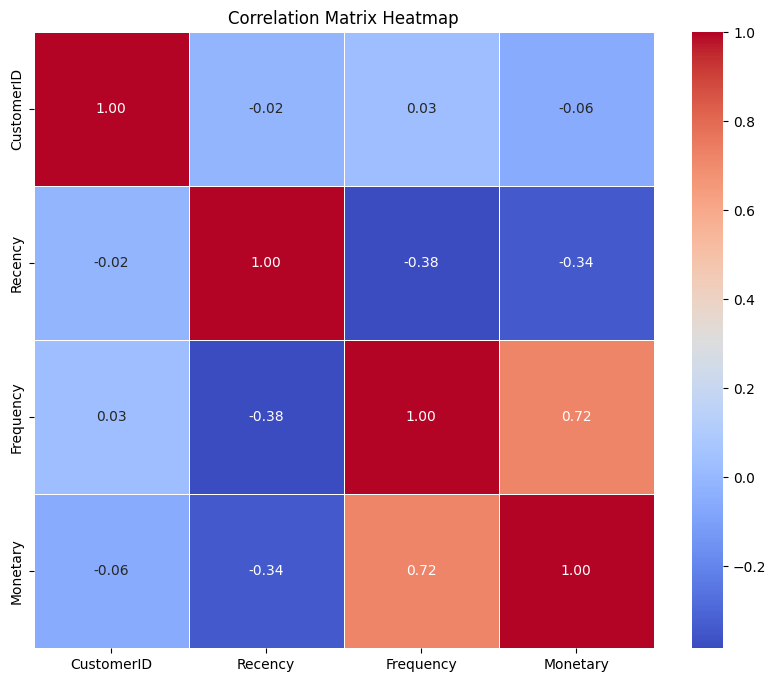

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 6.2 | Visualizing Correlation Matrix

# Set the size of the plot
plt.figure(figsize=(10, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Title and display the plot
plt.title('Correlation Matrix Heatmap')
plt.show()


# Feature Scaling
Feature scaling is essential in clustering algorithms like K-means because they are sensitive to the scale of the data. Common scaling techniques include Standardization (Z-score normalization) and Min-Max Scaling. Here, we'll use Standardization.

## Standardizing Features
Standardization transforms data to have a mean of 0 and a standard deviation of 1. This ensures that each feature contributes equally to the distance calculations in clustering algorithms.

In [26]:
from sklearn.preprocessing import StandardScaler

# Step 7.1 | Standardizing Features

# Select features to scale
features_to_scale = ['Recency', 'Frequency', 'Monetary']  # Add other features if needed

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit and transform the features
scaled_features = scaler.fit_transform(rfm_df_cleaned[features_to_scale])

# Convert the scaled features back to a DataFrame
scaled_features_df = pd.DataFrame(scaled_features, columns=features_to_scale)

# Concatenate the scaled features with the rest of the dataframe
rfm_df_scaled = rfm_df_cleaned.drop(columns=features_to_scale).join(scaled_features_df)

# Display the scaled dataframe
print("First few rows of the scaled dataset:")
print(rfm_df_scaled.head())


First few rows of the scaled dataset:
   CustomerID  Recency  Frequency  Monetary
1   12348.000   -0.812     -0.825     0.897
2   12349.000    2.433     -0.825    -0.725
3   12350.000   -0.622      2.049     0.851
4   12352.000    1.251     -0.825    -1.021
5   12353.000    1.563     -0.825     0.408


# Dimensionality Reduction
Dimensionality reduction helps in reducing the number of features while retaining important information. This can be particularly useful before applying clustering algorithms to simplify the data and improve performance. Common techniques for dimensionality reduction include Principal Component Analysis (PCA) and t-Distributed Stochastic Neighbor Embedding (t-SNE).

Here, I'll demonstrate how to use PCA for dimensionality reduction. PCA reduces the data to a smaller number of principal components that explain most of the variance in the dataset.

## Handle Missing Values
1. Impute Missing Values: You can fill missing values using various strategies such as mean, median, or a constant value.

2. Drop Missing Values: Alternatively, you can drop rows or columns containing missing values.

Here’s how to do both:

Option 1: Imputing Missing Values

In [28]:
from sklearn.impute import SimpleImputer

# Step 8.1 | Impute Missing Values

# Initialize the SimpleImputer with a strategy (mean, median, or constant)
imputer = SimpleImputer(strategy='mean')

# Impute missing values in the scaled features
rfm_df_scaled[features_to_scale] = imputer.fit_transform(rfm_df_scaled[features_to_scale])

# Check if there are any missing values remaining
print("Missing values after imputation:")
print(rfm_df_scaled.isnull().sum())


Missing values after imputation:
CustomerID    0
Recency       0
Frequency     0
Monetary      0
dtype: int64


## Applying PCA

PCA results:
   CustomerID    PC1   PC2
1   12348.000 -2.099 1.662
2   12349.000  2.103 0.327
3   12350.000 -1.743 0.504
4   12352.000 -0.994 1.316
5   12353.000 -1.461 0.803


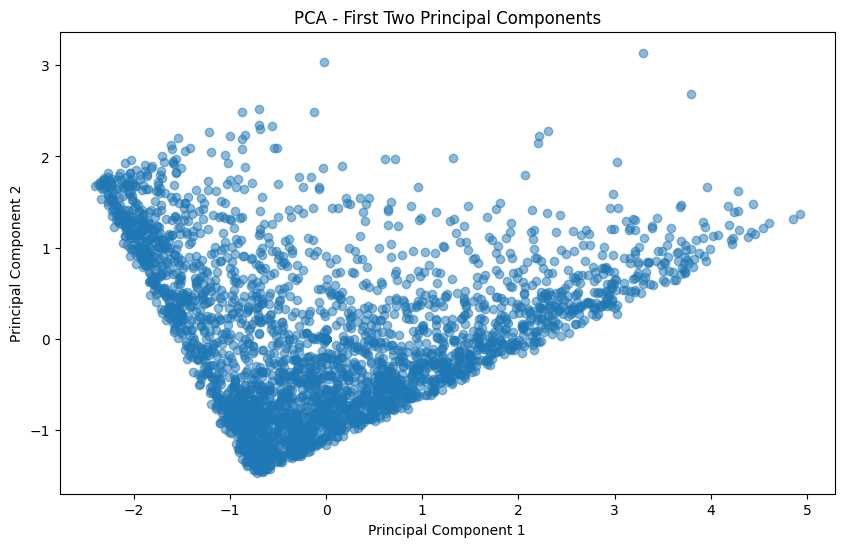

In [29]:
# Reinitialize PCA; here we reduce to 2 components for visualization
pca = PCA(n_components=2)

# Fit PCA on the scaled features
pca_result = pca.fit_transform(rfm_df_scaled[features_to_scale])

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Concatenate PCA results with the original CustomerID for identification
pca_df = pd.concat([rfm_df_cleaned[['CustomerID']], pca_df], axis=1)

# Display the first few rows of the PCA result
print("PCA results:")
print(pca_df.head())

# Optionally, visualize the PCA result
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)
plt.title('PCA - First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


# K-Means Clustering

## Determining the Optimal Number of Clusters
To determine the optimal number of clusters for K-Means, we commonly use the Elbow Method and the Silhouette Method.

### Elbow Method
The Elbow Method involves plotting the Sum of Squared Distances (SSD) between points and their cluster centroids as a function of the number of clusters. The "elbow" point in the plot indicates the optimal number of clusters.

In [32]:
# Check for NaN values in the PCA results
print("Missing values in PCA results:")
print(pca_df.isnull().sum())


Missing values in PCA results:
CustomerID    583
PC1           583
PC2           583
dtype: int64


In [34]:
# Impute Missing Values

from sklearn.impute import SimpleImputer

# Initialize the SimpleImputer with a strategy (mean, median, or constant)
imputer = SimpleImputer(strategy='mean')

# Impute missing values in PCA results
pca_df[['PC1', 'PC2']] = imputer.fit_transform(pca_df[['PC1', 'PC2']])

# Check if there are any missing values remaining
print("Missing values after imputation:")
print(pca_df.isnull().sum())


Missing values after imputation:
CustomerID    583
PC1             0
PC2             0
dtype: int64


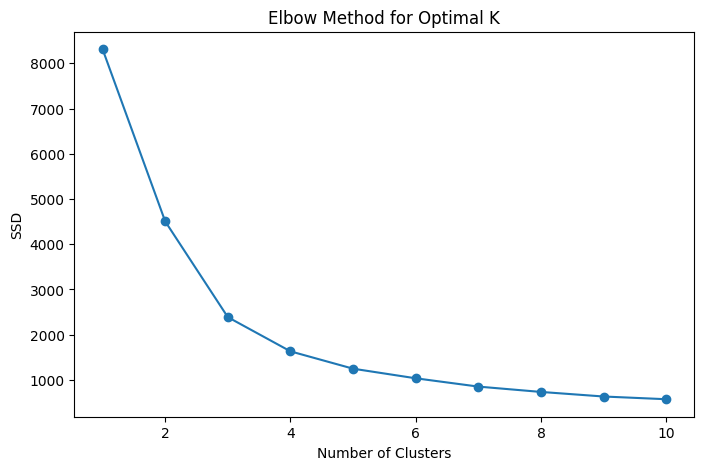

In [35]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 9.1.1 | Elbow Method

# Define the range of clusters to try
cluster_range = range(1, 11)  # Example range from 1 to 10 clusters
ssd = []

# Compute SSD for each number of clusters
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_df[['PC1', 'PC2']])
    ssd.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, ssd, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('SSD')
plt.show()


### Silhouette Method
The Silhouette Method measures how similar an object is to its own cluster compared to other clusters. It helps evaluate the quality of clustering.

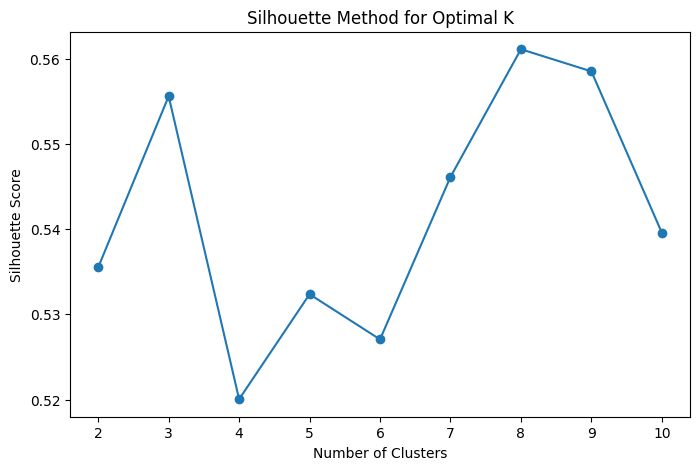

In [36]:
from sklearn.metrics import silhouette_score

# Step 9.1.2 | Silhouette Method

# Define the range of clusters to try
cluster_range = range(2, 11)  # Starting from 2 clusters, as silhouette score is not defined for 1 cluster
silhouette_scores = []

# Compute silhouette scores for each number of clusters
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(pca_df[['PC1', 'PC2']])
    silhouette_avg = silhouette_score(pca_df[['PC1', 'PC2']], labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Method graph
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


## Clustering Model - K-Means
After determining the optimal number of clusters, you can fit the K-Means model and assign cluster labels to your data.

PCA DataFrame with Cluster Labels:
   CustomerID    PC1   PC2  Cluster
1   12348.000 -2.099 1.662        3
2   12349.000  2.103 0.327        1
3   12350.000 -1.743 0.504        3
4   12352.000 -0.994 1.316        3
5   12353.000 -1.461 0.803        3


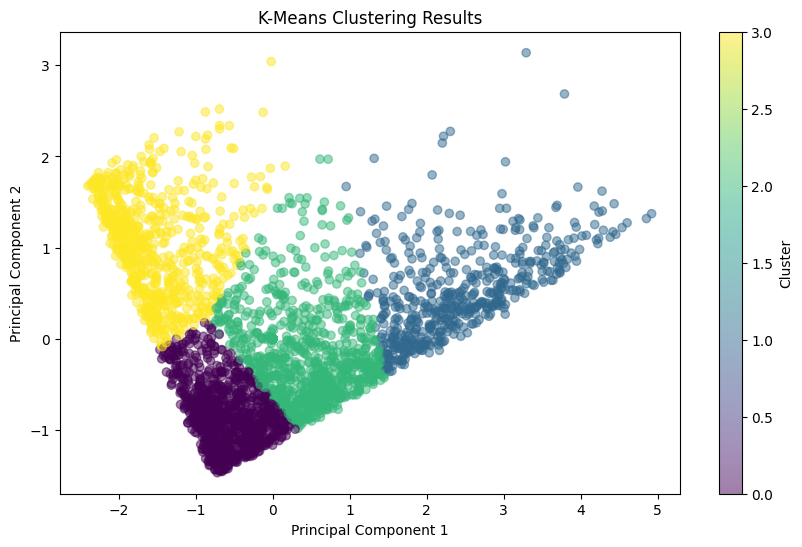

In [37]:
# Step 9.2 | Clustering Model - K-Means

# Choose the optimal number of clusters (example: 5 clusters from the elbow/silhouette method)
optimal_clusters = 4

# Initialize K-Means with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)

# Fit the K-Means model
pca_df['Cluster'] = kmeans.fit_predict(pca_df[['PC1', 'PC2']])

# Display the first few rows with cluster labels
print("PCA DataFrame with Cluster Labels:")
print(pca_df.head())

# Optionally, visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis', alpha=0.5)
plt.title('K-Means Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


# Clustering Evaluation

## 3D Visualization of Top Principal Components
For 3D visualization, we need to have three principal components. If we only have two, you may want to compute the third principal component or use other features for visualization.

Assuming you have three principal components, here’s how to visualize them:

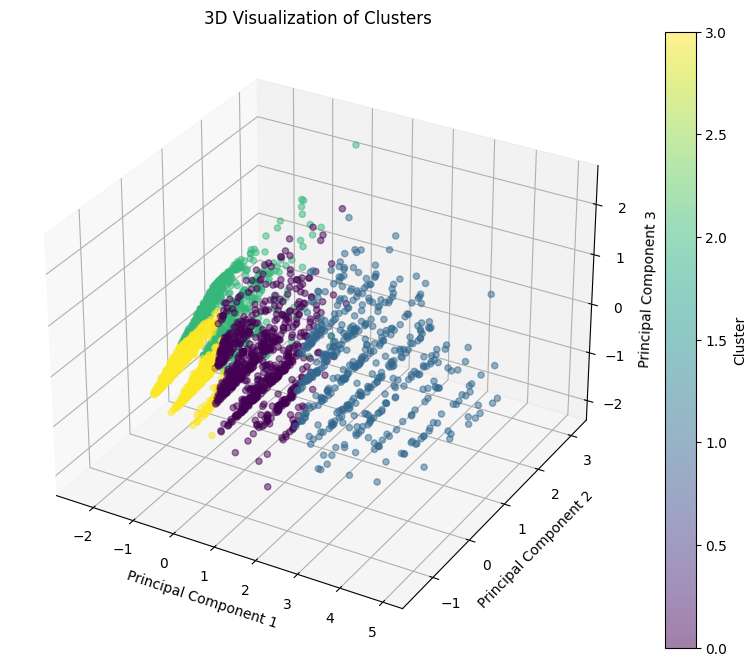

In [39]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming rfm_df_scaled is your scaled DataFrame used for clustering
# Ensure it's properly scaled and does not have missing values

# Step 1: Fit PCA on the scaled features
pca = PCA(n_components=3)
pca_result = pca.fit_transform(rfm_df_scaled[features_to_scale])

# Create a DataFrame with the PCA results
pca_df_3d = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])

# Step 2: Fit K-Means on the same scaled features
optimal_clusters = 4  # Set to your optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(rfm_df_scaled[features_to_scale])

# Add cluster labels to the DataFrame
pca_df_3d['Cluster'] = cluster_labels

# Step 3: 3D Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df_3d['PC1'], pca_df_3d['PC2'], pca_df_3d['PC3'],
                     c=pca_df_3d['Cluster'], cmap='viridis', alpha=0.5)

# Add color bar
plt.colorbar(scatter, label='Cluster')
ax.set_title('3D Visualization of Clusters')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()


##  Cluster Distribution Visualization
This involves visualizing how many data points are in each cluster.

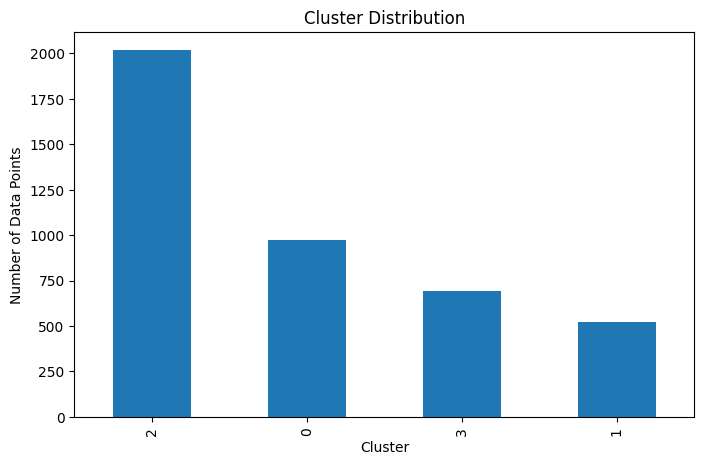

In [40]:
# Step 10.2 | Cluster Distribution Visualization

# Count the number of data points in each cluster
cluster_counts = pca_df['Cluster'].value_counts()

# Plot the distribution of clusters
plt.figure(figsize=(8, 5))
cluster_counts.plot(kind='bar')
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.show()


## Evaluation Metrics
Evaluation metrics for clustering include Silhouette Score and Davies-Bouldin Index. These metrics help evaluate the quality of clusters.

In [42]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Ensure that the DataFrame for PCA contains the same samples as used for clustering
# Fit PCA on the scaled features used for clustering
pca = PCA(n_components=2)
pca_result = pca.fit_transform(rfm_df_scaled[features_to_scale])

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Add cluster labels to the DataFrame
pca_df['Cluster'] = kmeans.labels_

# Step 10.3 | Evaluation Metrics

# Calculate silhouette score
silhouette_avg = silhouette_score(pca_df[['PC1', 'PC2']], pca_df['Cluster'])
print(f'Silhouette Score: {silhouette_avg:.3f}')

# Calculate Davies-Bouldin Index
davies_bouldin_avg = davies_bouldin_score(pca_df[['PC1', 'PC2']], pca_df['Cluster'])
print(f'Davies-Bouldin Index: {davies_bouldin_avg:.3f}')


Silhouette Score: 0.471
Davies-Bouldin Index: 0.715


# Cluster Analysis and Profiling

## Radar Chart Approach
A radar chart (or spider chart) is useful for visualizing the feature profiles of different clusters. Each axis represents a feature, and the distance from the center represents the value of that feature.

Here's how you can create a radar chart to analyze clusters:

   CustomerID  Recency  Frequency  Monetary    PC1    PC2  Cluster
0   12347.000    1.000      7.000  3552.815  2.540  0.338        0
1   12348.000   74.000      4.000  1437.240  0.372  0.009        2
2   12349.000   18.000      1.000  1417.600  0.007 -0.800        1
3   12350.000  309.000      1.000   294.400 -2.022  1.468        2
4   12352.000   35.000      7.000  1385.740  1.153 -0.068        2


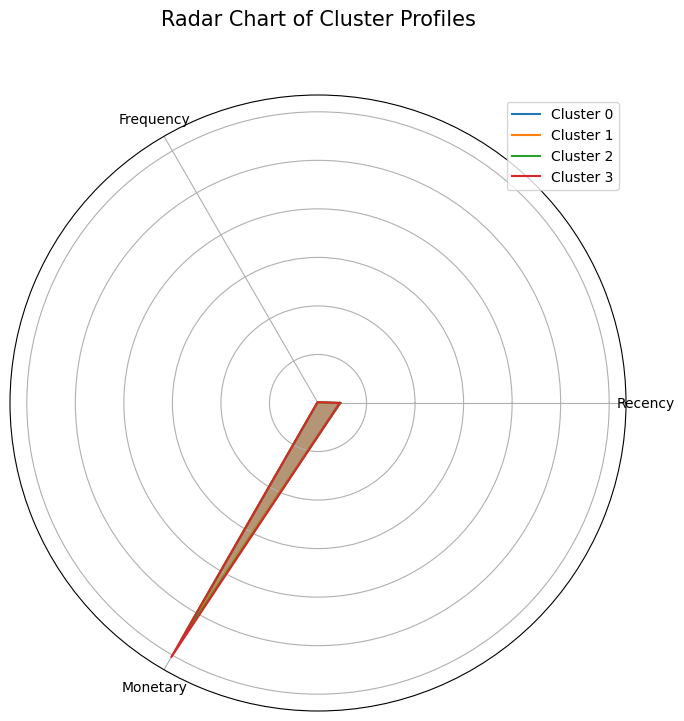

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming rfm_df is your original DataFrame
# Apply the same scaling and transformation used for PCA
scaler = StandardScaler()
rfm_df_scaled = scaler.fit_transform(rfm_df[features_to_scale])

# Perform PCA (if you already have PCA done, skip this part)
pca = PCA(n_components=2)  # Adjust the number of components based on your earlier steps
pca_df = pd.DataFrame(pca.fit_transform(rfm_df_scaled), columns=['PC1', 'PC2'])

# Now, use the same DataFrame for clustering
rfm_df['PC1'] = pca_df['PC1']
rfm_df['PC2'] = pca_df['PC2']

# Assuming kmeans is already fitted on pca_df[['PC1', 'PC2']]
rfm_df = rfm_df.iloc[:len(kmeans.labels_)]  # Ensure the DataFrame has the same length as the cluster labels
rfm_df['Cluster'] = kmeans.labels_

# Verify cluster column is added
print(rfm_df.head())

# Calculate mean values for each feature per cluster
cluster_profiles = rfm_df.groupby('Cluster')[features_to_scale].mean()

# Radar chart function remains the same
def plot_radar_chart(data, labels, title):
    num_vars = len(data.columns)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    for i, row in data.iterrows():
        values = row.values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, label=f'Cluster {i}')
        ax.fill(angles, values, alpha=0.25)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    plt.title(title, size=15, color='black', y=1.1)
    plt.legend(loc='upper right')
    plt.show()

# Plot radar chart
plot_radar_chart(cluster_profiles, features_to_scale, 'Radar Chart of Cluster Profiles')


## Histogram Chart Approach
Histogram charts help visualize the distribution of features for each cluster. This can give insights into the distribution and characteristics of each cluster.

Here's how to create histograms for each cluster:

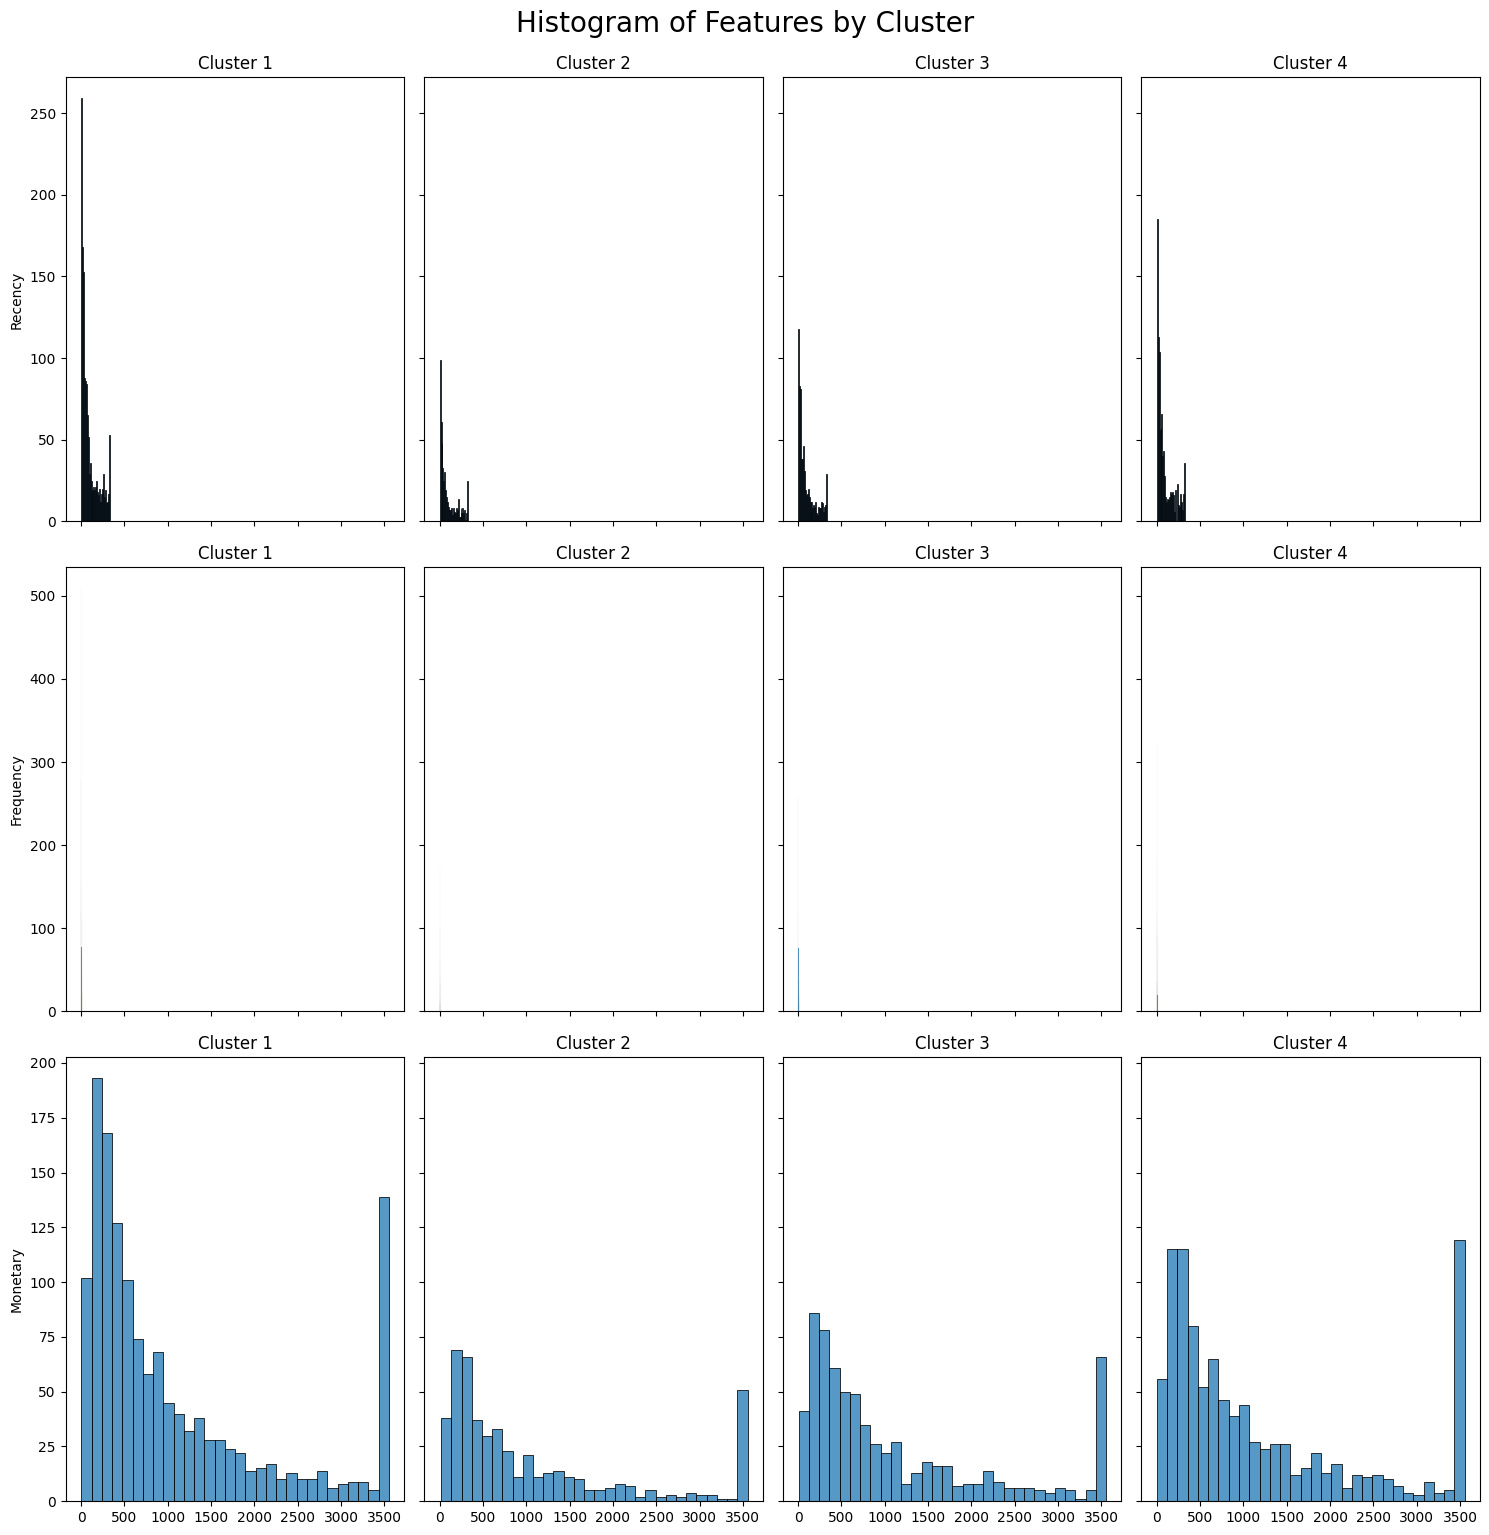

In [46]:
import seaborn as sns

def plot_histograms(data, feature_names, title):
    num_features = len(feature_names)
    num_clusters = data['Cluster'].nunique()

    fig, axes = plt.subplots(num_features, num_clusters, figsize=(15, num_features * 5), sharex='col', sharey='row')

    for i, feature in enumerate(feature_names):
        for j in range(num_clusters):
            cluster_data = data[data['Cluster'] == j][feature]
            sns.histplot(cluster_data, bins=30, ax=axes[i, j], kde=False)
            axes[i, j].set_title(f'Cluster {j+1}')
            axes[i, j].set_xlabel('')
            axes[i, j].set_ylabel(feature)

    plt.tight_layout()
    plt.suptitle(title, size=20, y=1.02)
    plt.show()

# Plot histograms for each feature and cluster
plot_histograms(rfm_df, features_to_scale, 'Histogram of Features by Cluster')
